<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/Feature_Selection_LGBMClassifier_on_agg_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import cross_val_score, cross_validate


import matplotlib.pyplot as plt


In [2]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [4]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [5]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [6]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [7]:
sgd = SGDClassifier()

In [8]:
%%time
sgd.fit(X,Y.to_numpy().ravel())

CPU times: user 49.3 s, sys: 4.9 s, total: 54.2 s
Wall time: 54 s


SGDClassifier()

In [9]:
%%time
sfs = SelectFromModel(sgd, prefit=True)


CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 18.1 µs


In [10]:
sfs.get_support().sum()

277

In [11]:
X_New = sfs.transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [12]:
X_New.shape

(458913, 277)

In [13]:
gc.collect()

44

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_New, Y, test_size=0.2)

In [15]:
X_train.shape

(367130, 277)

In [16]:
X_test.shape

(91783, 277)

In [17]:
gc.collect()

149

In [18]:
sm = KMeansSMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [19]:
X_train.shape

(543672, 277)

In [20]:
clf = gbm.LGBMClassifier()


In [21]:
accuracy_scores = cross_validate(clf, X_train, y_train.to_numpy().ravel(), cv=10,scoring=('f1', 'recall'), return_train_score=True,verbose=1000)
print(accuracy_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END  f1: (train=0.942, test=0.842) recall: (train=0.939, test=0.770) total time=  36.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.5s remaining:    0.0s
[CV] START .....................................................................
[CV] END  f1: (train=0.941, test=0.845) recall: (train=0.939, test=0.774) total time=  36.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[CV] START .....................................................................
[CV] END  f1: (train=0.942, test=0.843) recall: (train=0.939, test=0.772) total time=  36.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s
[CV] START .....................................................................
[CV] END  f1: (train=0.936, test=0.915) recall: (train=0.937, test=0.901) to

In [23]:
accuracy_scores['test_f1'].mean()

0.9221853559315057

In [24]:
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier()

In [25]:
clf.score(X_test, y_test)

0.8986413606005469

In [26]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [27]:
y_pred = clf.predict(X_test)

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [29]:
tn, fp, fn, tp

(63537, 4713, 4590, 18943)

In [30]:
f1_score(y_test, y_pred)

0.8028565979359595

In [31]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9326    0.9309    0.9318     68250
           1     0.8008    0.8050    0.8029     23533

    accuracy                         0.8986     91783
   macro avg     0.8667    0.8679    0.8673     91783
weighted avg     0.8988    0.8986    0.8987     91783



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


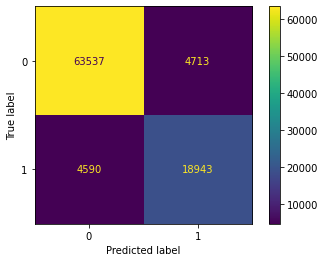

In [32]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [33]:
cols = sgd.feature_names_in_[sfs.get_support()]

In [34]:
feature_importance_df = pd.DataFrame(
    {'feature': cols ,
     'importance': clf.feature_importances_})

In [35]:
feature_importance_df.sort_values(by='importance', ascending=False).head(600)

,feature,importance
3,P_2_last,151
7,D_39_last,96
145,D_69_max,94
9,B_1_last,93
249,B_40_max,85
...,...,...
32,B_4_mean,0
218,D_91_max,0
64,B_9_min,0
150,S_15_std,0
